In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import zscore, shapiro
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("Champions_Group_2025.csv")

In [4]:
def handle_outliers(df, cols):
    df_clean = df.copy()
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df_clean[col] = df_clean[col].clip(lower, upper)
    return df_clean


In [5]:
columns_to_drop = ['AccountID', 'Industry', '8-Digit SIC Description', 'Parent Company',
                  'Parent Country', 'Company Description', 'Fiscal Year End']

df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

date_cols = [col for col in df.columns if df[col].astype(str).str.contains('T').any()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[f"{col}_year"] = df[col].dt.year
    df.drop(columns=[col], inplace=True)

Domestic Ultimate - Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2908
           1       0.88      0.93      0.90      2929

    accuracy                           0.90      5837
   macro avg       0.90      0.90      0.90      5837
weighted avg       0.90      0.90      0.90      5837

Global Ultimate - Accuracy: 0.93


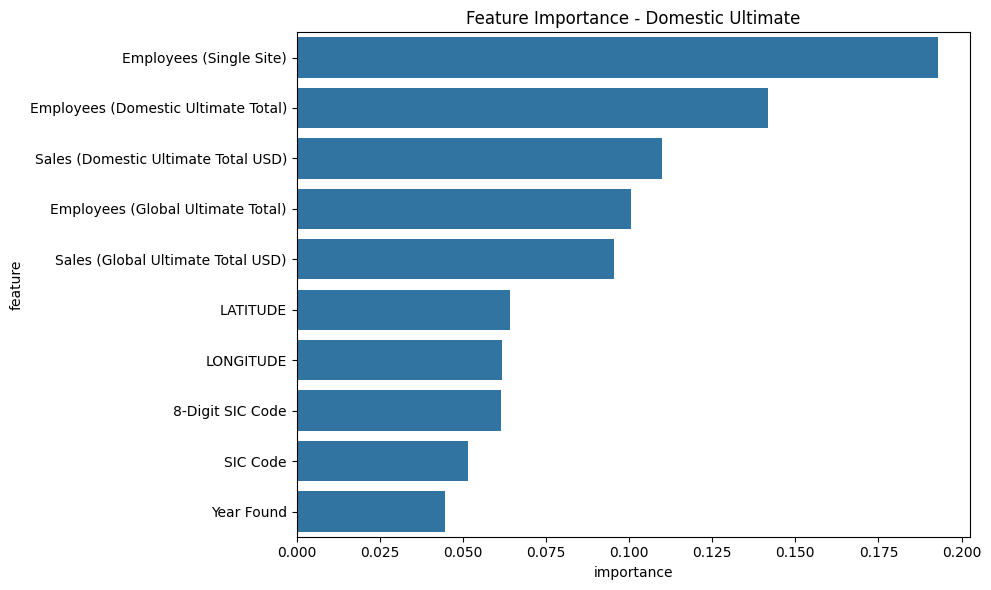

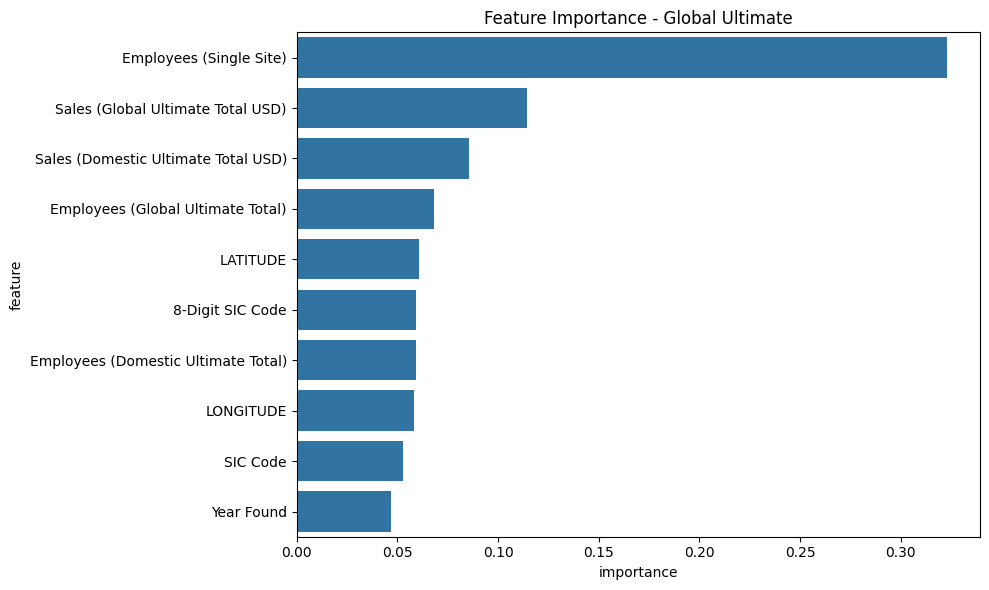

In [6]:
if 'Year Found' in df.columns:
    df['Company Age'] = pd.to_datetime('today').year - df['Year Found']


if all(col in df.columns for col in ['Employees (Single Site)', 'Employees (Domestic Ultimate Total)']):
    df['Employee Domestic Ratio'] = df['Employees (Single Site)'] / df['Employees (Domestic Ultimate Total)']

if all(col in df.columns for col in ['Employees (Domestic Ultimate Total)', 'Employees (Global Ultimate Total)']):
    df['Employee Global Ratio'] = df['Employees (Domestic Ultimate Total)'] / df['Employees (Global Ultimate Total)']

if all(col in df.columns for col in ['Sales (Domestic Ultimate Total USD)', 'Sales (Global Ultimate Total USD)']):
    df['Sales Global Ratio'] = df['Sales (Domestic Ultimate Total USD)'] / df['Sales (Global Ultimate Total USD)']


num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")


df.replace([np.inf, -np.inf], np.nan, inplace=True) #replacing values w infinity
df.fillna(df.select_dtypes(include=['number']).median(), inplace=True)

cols_for_outlier_handling = ['Employee Domestic Ratio', 'Employee Global Ratio',
                            'Sales Global Ratio', 'Company Age']

df = handle_outliers(df, cols_for_outlier_handling)



df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


target_domestic = "Is Domestic Ultimate"
target_global = "Is Global Ultimate"
df[target_domestic] = df[target_domestic].astype(int)
df[target_global] = df[target_global].astype(int)
##### Spliting the training and testing data
features = df.drop(columns=[target_domestic, target_global])
X_train_dom, X_test_dom, y_train_dom, y_test_dom = train_test_split(features, df[target_domestic], test_size=0.2, random_state=42)
X_train_glob, X_test_glob, y_train_glob, y_test_glob = train_test_split(features, df[target_global], test_size=0.2, random_state=42)

##### Training models
rf_model_dom = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_dom.fit(X_train_dom, y_train_dom)

rf_model_glob = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_glob.fit(X_train_glob, y_train_glob)

##### Predictions
y_pred_dom = rf_model_dom.predict(X_test_dom)
y_pred_glob = rf_model_glob.predict(X_test_glob)

##### PRINT RESULTS
print(f"Domestic Ultimate - Accuracy: {accuracy_score(y_test_dom, y_pred_dom):.2f}")
print(classification_report(y_test_dom, y_pred_dom))
print(f"Global Ultimate - Accuracy: {accuracy_score(y_test_glob, y_pred_glob):.2f}")

# Plot feature importance for both models
def plot_feature_importance(model, features, title):
    importance = pd.DataFrame({
        'feature': features.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(data=importance.head(10), x='importance', y='feature')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_model_dom, features, 'Feature Importance - Domestic Ultimate')
plot_feature_importance(rf_model_glob, features, 'Feature Importance - Global Ultimate')